In [1]:
import numpy as np
import sympy
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow import keras
from tensorflow.keras.layers import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import roc_curve, auc, accuracy_score, r2_score
from tensorflow.keras.regularizers import Regularizer
from tensorflow.keras.initializers import Zeros, RandomNormal
np.random.seed(123)
tf.random.set_seed(123)

# LHC jet tagging

In [ ]:
from sklearn.datasets import fetch_openml
data = fetch_openml('hls4ml_lhc_jets_hlf')
X, Y = data['data'].to_numpy(), data['target'].to_numpy()

print(data['feature_names'])
print(X.shape, Y.shape)
print(Y[:3])

LE = LabelEncoder()
Y = LE.fit_transform(Y)
print(Y[:3])

Y = to_categorical(Y, 5)
print(Y[:3])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.5, random_state=42)

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

X_train = X_train[:100000]
Y_train = Y_train[:100000]
X_test = X_test[:100000]
Y_test = Y_test[:100000]

print("X_train.shape: " + str(X_train.shape))
print("Y_train.shape: " + str(Y_train.shape))
print("X_test.shape: " + str(X_test.shape))
print("Y_test.shape: " + str(Y_test.shape))

# MNIST

In [2]:
(X_train, Y_train), (X_test, Y_test) = keras.datasets.mnist.load_data()
X_train = np.reshape(X_train, (X_train.shape[0], 28, 28, 1)) / 255.
X_test = np.reshape(X_test, (X_test.shape[0], 28, 28, 1)) / 255.

def select_classes(x, y, classes):
    idx = (y == 99)
    for i in range(len(classes)):
        idx |= (y == classes[i])
    x, y = x[idx], y[idx]
    return x, y

classes = [0,1,2,3,4,5,6,7,8,9]
X_train, Y_train = select_classes(X_train, Y_train, classes)
X_test, Y_test = select_classes(X_test, Y_test, classes)

LE = LabelEncoder()
Y_train = LE.fit_transform(Y_train)
Y_test = LE.fit_transform(Y_test)

Y_train = to_categorical(Y_train, len(classes))
Y_test = to_categorical(Y_test, len(classes))

X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))

print("X_train.shape: " + str(X_train.shape))
print("Y_train.shape: " + str(Y_train.shape))
print("X_test.shape: " + str(X_test.shape))
print("Y_test.shape: " + str(Y_test.shape))

X_train.shape: (60000, 784)
Y_train.shape: (60000, 10)
X_test.shape: (10000, 784)
Y_test.shape: (10000, 10)


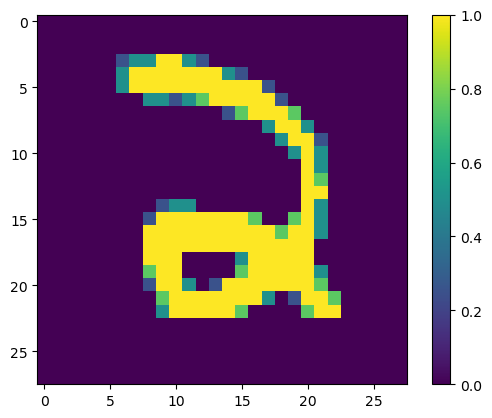

In [3]:
plt.imshow(X_train[Y_train[:,2]==1][1234].reshape((28,28,1)))
plt.colorbar()

# Model

#### Define unary and binary operators

In [4]:
# tf_or_sympy = 'tf' for model building and training
# tf_or_sympy = 'sympy' for get_expressions later (write sympy expressions by unrolling network)
def math_operation(tf_or_sympy, operator, x, y=None):
    # unary operators
    if operator == 'identity':
        output = x
    elif operator == 'sin':
        output = tf.sin(x) if tf_or_sympy == 'tf' else sympy.sin(x)
    elif operator == 'cos':
        output = tf.cos(x) if tf_or_sympy == 'tf' else sympy.cos(x)
    elif operator == 'exp':
        output = tf.exp(x) if tf_or_sympy == 'tf' else sympy.exp(x)
    elif operator == 'gauss':
        output = tf.exp(-x**2) if tf_or_sympy == 'tf' else sympy.exp(-x**2)
    elif operator == 'sinh':
        output = tf.sinh(x) if tf_or_sympy == 'tf' else sympy.sinh(x)
    elif operator == 'cosh':
        output = tf.cosh(x) if tf_or_sympy == 'tf' else sympy.cosh(x)
    elif operator == 'tanh':
        output = tf.tanh(x) if tf_or_sympy == 'tf' else sympy.tanh(x)
    elif operator == 'square':
        output = x**2 if tf_or_sympy == 'tf' else x**2
    elif operator == 'cube':
        output = x**3 if tf_or_sympy == 'tf' else x**3
    elif operator == 'log':
        output = tf.math.log(0.001 + tf.abs(x)) if tf_or_sympy == 'tf' else sympy.log(0.001 + sympy.Abs(x))
        #output = tf.math.log(tf.abs(x)) if tf_or_sympy == 'tf' else sympy.log(sympy.Abs(x))
    # binary operators
    elif operator == '+':
        output = x + y
    elif operator == '*':
        output = x * y
    elif operator == 'pow':
        output = x ** y
    elif operator == '/':
        output = x / (0.001 + tf.abs(y)) if tf_or_sympy == 'tf' else x / (0.001 + sympy.Abs(y))
        #output = x / y
    
    return output

#### Architecture

In [5]:
# step function for masking in the forward pass
# custom grad is an estimator of derivative of the step function to avoid vanishing gradient
@tf.custom_gradient
def step_func(x):
    func = tf.where(x > 0., 1., 0.)
    def grad(upstream):
        a = 5.
        return upstream * a * tf.exp(-a*x) / (1 + tf.exp(-a*x))**2
    return func, grad

# dynamic pruning of input features
# define one auxiliary weight and one untrainable threshold per input feature
class Input_sparsity(Layer):
    def __init__(self):
        super().__init__()
        
    def build(self, input_shape):
        # auxiliary weight is untrainable and fixed at 1
        self.aux_w = self.add_weight(name='weight',
                                     shape=(input_shape[-1],),
                                     initializer='ones',
                                     trainable=False)
        # threshold is trainable, initialized at 0, and bounded in [0,1]
        self.aux_w_t = self.add_weight(name='threshold',
                                     shape=(input_shape[-1],),
                                     initializer='zeros',
                                     constraint=lambda x: tf.clip_by_value(x, 0., 1.),
                                     trainable=True)
        
    def call(self, inputs):
        input_masks = step_func(self.aux_w - self.aux_w_t)
        return tf.multiply(inputs, input_masks)

# definition of symbolic layer (usual weights and biases, plus unary/binary operators as activations)
# define trainable thresholds for weights/biases/unary/binary
class Symbolic_Layer(Layer):
    def __init__(self, operators, num_operators):
        super().__init__()
        self.operators = operators
        self.num_operators = num_operators
        self.units = self.num_operators[0] + 2*self.num_operators[1]
        
    def build(self, input_shape):
        # usual model weight w
        self.w = self.add_weight(name='weight',
                                 shape=(input_shape[-1], self.units),
                                 initializer='random_normal',
                                 trainable=True)
        # usual bias b
        self.b = self.add_weight(name='bias',
                                 shape=(self.units,),
                                 initializer='random_normal',
                                 trainable=True)
        # auxiliary weight for unary operator, to be used for operator pruning
        # untrainable and fixed at 1
        self.aux_unary = self.add_weight(name='unary',
                                         shape=(self.num_operators[0],),
                                         initializer='ones',
                                         trainable=False)
        # auxiliary weight for binary operator, to be used for operator pruning
        # untrainable and fixed at 1
        if self.num_operators[1] > 0:
            self.aux_binary = self.add_weight(name='binary',
                                              shape=(self.num_operators[1],),
                                              initializer='ones',
                                              trainable=False)
        # threshold for model weight
        # trainable, initialized at 0, unbounded since model weight is unbounded
        self.aux_w_t = self.add_weight(name='weight_threshold',
                                       shape=(input_shape[-1], self.units),
                                       initializer='zeros',
                                       constraint=lambda x: tf.abs(x),
                                       trainable=True)
        # threshold for bias term
        # trainable, initialized at 0, unbounded since model weight is unbounded
        self.aux_b_t = self.add_weight(name='bias_threshold',
                                       shape=(self.units,),
                                       initializer='zeros',
                                       constraint=lambda x: tf.abs(x),
                                       trainable=True)
        # threshold for unary operator
        # trainable, initialized at 0, bounded in [0,1]
        self.aux_unary_t = self.add_weight(name='unary_threshold',
                                          shape=(self.num_operators[0],),
                                          initializer='zeros',
                                          constraint=lambda x: tf.clip_by_value(x, 0., 1.),
                                          trainable=True)
        # threshold for binary operator
        # trainable, initialized at 0, bounded in [0,1]
        if self.num_operators[1] > 0:
            self.aux_binary_t = self.add_weight(name='binary_threshold',
                                                shape=(self.num_operators[1],),
                                                initializer='zeros',
                                                constraint=lambda x: tf.clip_by_value(x, 0., 1.),
                                                trainable=True)

    def call(self, inputs):
        # linear transformation in the forward pass
        # weights and biases are replaced by the step_functioned version
        # so weight is masked whenever its threshold is higher
        w_masks = step_func(tf.abs(self.w) - self.aux_w_t)
        b_masks = step_func(tf.abs(self.b) - self.aux_b_t)
        linear_output = tf.matmul(inputs, tf.multiply(self.w, w_masks)) + tf.multiply(self.b, b_masks)
        
        # activation by unary/binary operator
        symbolic_output = []
        
        # loop over number of unary operators in a symbolic layer
        for i in range(self.num_operators[0]):
            # an unary operator is "pruned" (becomes identity map) whenever the threshold is higher than its auxiliary weight
            unary_mask = step_func(self.aux_unary - self.aux_unary_t)[i]
            idx = np.mod(i, len(self.operators[0]))
            unary_operation = (unary_mask * math_operation('tf',self.operators[0][idx],linear_output[:, i:i+1]) +
                               (1.0 - unary_mask) * math_operation('tf','identity',linear_output[:, i:i+1]))
            symbolic_output.append(unary_operation)
            
        # loop over number of binary operators in a symbolic layer
        for i in range(self.num_operators[0], self.num_operators[0] + 2*self.num_operators[1], 2):
            # a binary operator is "pruned" (becomes addition) whenever the threshold is higher than its auxiliary weight
            j = int((i - self.num_operators[0])/2)
            binary_mask = step_func(self.aux_binary - self.aux_binary_t)[j]
            idx = np.mod(j, len(self.operators[1]))
            binary_operation = (binary_mask * math_operation('tf',self.operators[1][idx],linear_output[:, i:i+1],linear_output[:, i+1:i+2]) +
                                (1.0 - binary_mask) * math_operation('tf','+',linear_output[:, i:i+1],linear_output[:, i+1:i+2]))
            symbolic_output.append(binary_operation)
        
        symbolic_output = tf.concat(symbolic_output, axis=1)
        return symbolic_output
    
def create_model(model_dim, operators, num_operators):
    input_dim, num_hidden_layers, output_dim = model_dim
    layers = []
    
    # input layer
    layers.append(Input(shape=(input_dim,)))
    layers.append(Input_sparsity()(layers[-1]))
    
    # hidden symbolic layers
    for i in range(num_hidden_layers):
        layers.append(Symbolic_Layer(operators=operators[i],
                                     num_operators=num_operators[i])(layers[-1]))
    
    # output layer
    layers.append(Symbolic_Layer(operators=[['identity'], [None]],
                                 num_operators=[output_dim, 0])(layers[-1]))
    
    model = keras.Model(inputs=layers[0], outputs=layers[-1], name='model')
    return model, model_dim, operators, num_operators

input_dim  = X_train.shape[1]
num_hidden = 1
output_dim = Y_train.shape[1]
model_dim = [input_dim, num_hidden, output_dim]

# operator choices per hidden symbolic layer
operators = [
    [['sin','cos','exp','gauss'], ['*']], # 1st symbolic layer [[unary], [binary]]
    #[['sin','cos','exp','gauss'], ['*']], # 2nd ...
            ]

# number of unary and binary operators per hidden symbolic layer
num_operators = [
    [20, 5], # 1st symbolic layer [num_unary, num_binary]
    #[20, 10], # 2nd ...
]

model = create_model(model_dim=model_dim,
                     operators=operators,
                     num_operators=num_operators)
model[0].summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 input_sparsity (Input_spar  (None, 784)               1568      
 sity)                                                           
                                                                 
 symbolic__layer (Symbolic_  (None, 25)                47150     
 Layer)                                                          
                                                                 
 symbolic__layer_1 (Symboli  (None, 10)                540       
 c_Layer)                                                        
                                                                 
Total params: 49258 (192.41 KB)
Trainable params: 48439 (189.21 KB)
Non-trainable params: 819 (3.20 KB)
_______________________

#### Define training loss

In [6]:
class neuralSR(keras.Model):
    def __init__(self, model, alpha_sparsity_input, alpha_sparsity_model, alpha_sparsity_unary, alpha_sparsity_binary):
        super().__init__()
        self.model, self.model_dim, self.operators, self.num_operators = model
        self.alpha_sparsity_input = alpha_sparsity_input
        self.alpha_sparsity_model = alpha_sparsity_model
        self.alpha_sparsity_unary = alpha_sparsity_unary
        self.alpha_sparsity_binary = alpha_sparsity_binary
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.regression_loss_tracker = keras.metrics.Mean(name="regression_loss")
        self.threshold_input_reg_loss_tracker = keras.metrics.Mean(name="threshold_input_reg_loss")
        self.threshold_input_mean_tracker = keras.metrics.Mean(name="threshold_input_mean")
        self.threshold_model_reg_loss_tracker = keras.metrics.Mean(name="threshold_model_reg_loss")
        self.threshold_model_mean_tracker = keras.metrics.Mean(name="threshold_model_mean")
        self.threshold_unary_reg_loss_tracker = keras.metrics.Mean(name="threshold_unary_reg_loss")
        self.threshold_unary_mean_tracker = keras.metrics.Mean(name="threshold_unary_mean")
        self.threshold_binary_reg_loss_tracker = keras.metrics.Mean(name="threshold_binary_reg_loss")
        self.threshold_binary_mean_tracker = keras.metrics.Mean(name="threshold_binary_mean")
        self.weight_input_mean_tracker = keras.metrics.Mean(name="weight_input_mean")
        self.weight_model_mean_tracker = keras.metrics.Mean(name="weight_model_mean")
        self.weight_unary_mean_tracker = keras.metrics.Mean(name="weight_unary_mean")
        self.weight_binary_mean_tracker = keras.metrics.Mean(name="weight_binary_mean")
        self.sparsity_input_tracker = keras.metrics.Mean(name="sparsity_input")
        self.sparsity_model_tracker = keras.metrics.Mean(name="sparsity_model")
        self.sparsity_unary_tracker = keras.metrics.Mean(name="sparsity_unary")
        self.sparsity_binary_tracker = keras.metrics.Mean(name="sparsity_binary")
        self.accuracy_tracker = keras.metrics.Accuracy(name="accuracy")
    
    def get_hyperparameters(self):
        return self.model_dim, self.operators, self.num_operators
        
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.regression_loss_tracker,
            self.threshold_input_reg_loss_tracker,
            self.threshold_input_mean_tracker,
            self.threshold_model_reg_loss_tracker,
            self.threshold_model_mean_tracker,
            self.threshold_unary_reg_loss_tracker,
            self.threshold_unary_mean_tracker,
            self.threshold_binary_reg_loss_tracker,
            self.threshold_binary_mean_tracker,
            self.weight_input_mean_tracker,
            self.weight_model_mean_tracker,
            self.weight_unary_mean_tracker,
            self.weight_binary_mean_tracker,
            self.sparsity_input_tracker,
            self.sparsity_model_tracker,
            self.sparsity_unary_tracker,
            self.sparsity_binary_tracker,
            self.accuracy_tracker
        ]
    
    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            y_pred = self.model(x)
            
            # base training loss (MSE)
            regression_loss = tf.reduce_mean(tf.reduce_sum(tf.cast((y-y_pred)**2,dtype=tf.float64), axis=1))
            
            # the followings calculate sparsity levels at train steps
            # since total loss = MSE + sparsity regularization terms
            # where sparsity regularization terms depend on sparsity levels
            
            # call auxiliary weights and thresholds for inputs
            w_input = self.non_trainable_weights[0]
            w_t_input = self.trainable_weights[0]
            num_input_masks = tf.reduce_sum(tf.cast(tf.where(w_input - w_t_input > 0., 0., 1.), dtype=tf.float64))
            num_input_weights = tf.size(w_input, out_type=tf.float64)
            sparsity_input = num_input_masks/num_input_weights
            weight_input_mean = tf.reduce_sum(tf.cast(tf.abs(w_input),dtype=tf.float64))/num_input_weights
            
            # calculate input sparsity
            t_input_sum = tf.reduce_sum(tf.cast(w_t_input,dtype=tf.float64))
            t_input_dim = num_input_weights
            threshold_input_mean = t_input_sum/t_input_dim
            
            # call model weights and thresholds for all hidden symbolic layers
            # then calculate model weight (weight+bias) sparsity
            num_model_masks = 0.
            num_model_weights = 0.
            weight_model_mean = 0.
            t_model_sum = 0.
            t_model_dim = 0.
            sum_exp_t = 0.
            for i in range(self.model_dim[1]+1):
                w_model = self.trainable_weights[1+6*i]
                b_model = self.trainable_weights[1+6*i+1]
                w_t_model = self.trainable_weights[1+6*i+2]
                b_t_model = self.trainable_weights[1+6*i+3]
                sum_exp_t += tf.reduce_sum(tf.exp(-tf.cast(w_t_model,dtype=tf.float64)))
                sum_exp_t += tf.reduce_sum(tf.exp(-tf.cast(b_t_model,dtype=tf.float64)))
                num_model_masks += tf.reduce_sum(tf.cast(tf.where(-w_t_model + tf.abs(w_model) > 0., 0., 1.),dtype=tf.float64))
                num_model_masks += tf.reduce_sum(tf.cast(tf.where(-b_t_model + tf.abs(b_model) > 0., 0., 1.),dtype=tf.float64))
                num_model_weights += tf.size(w_model, out_type=tf.float64)
                num_model_weights += tf.size(b_model, out_type=tf.float64)
                weight_model_mean += tf.reduce_sum(tf.cast(tf.abs(w_model),dtype=tf.float64)) + tf.reduce_sum(tf.cast(tf.abs(b_model),dtype=tf.float64))
                t_model_dim += tf.size(w_t_model, out_type=tf.float64) + tf.size(b_t_model, out_type=tf.float64)
                t_model_sum += tf.reduce_sum(tf.cast(w_t_model,dtype=tf.float64)) + tf.reduce_sum(tf.cast(b_t_model,dtype=tf.float64))
            sparsity_model = num_model_masks/num_model_weights
            weight_model_mean = weight_model_mean/num_model_weights

            threshold_model_mean = t_model_sum/t_model_dim
            
            # call auxiliary weights and thresholds for unary and binary operators
            num_unary_masks = 0.
            num_unary_weights = 0.
            weight_unary_mean = 0.
            num_binary_masks = 0.
            num_binary_weights = 0.
            weight_binary_mean = 0.
            t_u_sum = 0.
            t_u_dim = 0.
            t_b_sum = 0.
            t_b_dim = 0.
            for i in range(self.model_dim[1]):
                u = self.non_trainable_weights[2*i+1]
                u_t = self.trainable_weights[1+6*i+4]
                num_unary_masks += tf.reduce_sum(tf.cast(tf.where(u - u_t > 0., 0., 1.),dtype=tf.float64))
                num_unary_weights += tf.size(u, out_type=tf.float64)
                weight_unary_mean += tf.reduce_sum(tf.cast(u,dtype=tf.float64))
                t_u_dim += tf.size(u_t, out_type=tf.float64)
                t_u_sum += tf.reduce_sum(tf.cast(u_t,dtype=tf.float64))
                
                b = self.non_trainable_weights[2*i+2]
                b_t = self.trainable_weights[1+6*i+5]
                num_binary_masks += tf.reduce_sum(tf.cast(tf.where(b - b_t > 0., 0., 1.),dtype=tf.float64))
                num_binary_weights += tf.size(b, out_type=tf.float64)
                weight_binary_mean += tf.reduce_sum(tf.cast(b,dtype=tf.float64))
                t_b_dim += tf.size(b_t, out_type=tf.float64)
                t_b_sum += tf.reduce_sum(tf.cast(b_t,dtype=tf.float64))
                    
            # calculate sparsity levels for unary and binary operators
            sparsity_unary = num_unary_masks/num_unary_weights
            sparsity_binary = num_binary_masks/num_binary_weights
            weight_unary_mean = weight_unary_mean/num_unary_weights
            weight_binary_mean = weight_binary_mean/num_binary_weights
            
            threshold_unary_mean = t_u_sum/t_u_dim
            threshold_binary_mean = t_b_sum/t_b_dim
            
            # sparsity regularization terms
            threshold_input_reg_loss = regression_loss*tf.exp(-threshold_input_mean)
            threshold_model_reg_loss = regression_loss*sum_exp_t/num_model_weights
            threshold_unary_reg_loss = regression_loss*tf.exp(-threshold_unary_mean)
            threshold_binary_reg_loss = regression_loss*tf.exp(-threshold_binary_mean)
            # additional decay factor
            def reg(s, s_t, d):
                return tf.exp(-(s_t/(s_t-tf.minimum(s, s_t)))**d+1.)
            threshold_input_reg_loss *= reg(sparsity_input, self.alpha_sparsity_input, 0.01)
            threshold_model_reg_loss *= reg(sparsity_model, self.alpha_sparsity_model, 0.01)
            threshold_unary_reg_loss *= reg(sparsity_unary, self.alpha_sparsity_unary, 0.01)
            threshold_binary_reg_loss *= reg(sparsity_binary, self.alpha_sparsity_binary, 0.01)
            
            # total loss
            total_loss = regression_loss + (threshold_model_reg_loss + 
                                            threshold_input_reg_loss + 
                                            threshold_unary_reg_loss +
                                            threshold_binary_reg_loss)
            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
                
        self.total_loss_tracker.update_state(total_loss)
        self.regression_loss_tracker.update_state(regression_loss)
        self.threshold_input_reg_loss_tracker.update_state(threshold_input_reg_loss)
        self.threshold_input_mean_tracker.update_state(threshold_input_mean)
        self.threshold_model_reg_loss_tracker.update_state(threshold_model_reg_loss)
        self.threshold_model_mean_tracker.update_state(threshold_model_mean)
        self.threshold_unary_reg_loss_tracker.update_state(threshold_unary_reg_loss)
        self.threshold_unary_mean_tracker.update_state(threshold_unary_mean)
        self.threshold_binary_reg_loss_tracker.update_state(threshold_binary_reg_loss)
        self.threshold_binary_mean_tracker.update_state(threshold_binary_mean)
        self.weight_model_mean_tracker.update_state(weight_model_mean)
        self.weight_input_mean_tracker.update_state(weight_input_mean)
        self.weight_unary_mean_tracker.update_state(weight_unary_mean)
        self.weight_binary_mean_tracker.update_state(weight_binary_mean)
        self.accuracy_tracker.update_state(tf.argmax(y, axis=1), tf.argmax(y_pred, axis=1))
        self.sparsity_input_tracker.update_state(sparsity_input)
        self.sparsity_model_tracker.update_state(sparsity_model)
        self.sparsity_unary_tracker.update_state(sparsity_unary)
        self.sparsity_binary_tracker.update_state(sparsity_binary)
        return {
            'loss': self.total_loss_tracker.result(),
            'regression_loss': self.regression_loss_tracker.result(),
            'threshold_input_reg_loss': self.threshold_input_reg_loss_tracker.result(),
            'threshold_input_mean': self.threshold_input_mean_tracker.result(),
            'threshold_model_reg_loss': self.threshold_model_reg_loss_tracker.result(),
            'threshold_model_mean': self.threshold_model_mean_tracker.result(),
            'threshold_unary_reg_loss': self.threshold_unary_reg_loss_tracker.result(),
            'threshold_unary_mean': self.threshold_unary_mean_tracker.result(),
            'threshold_binary_reg_loss': self.threshold_binary_reg_loss_tracker.result(),
            'threshold_binary_mean': self.threshold_binary_mean_tracker.result(),
            'weight_model_mean': self.weight_model_mean_tracker.result(),
            #'weight_input_mean': self.weight_input_mean_tracker.result(),
            #'weight_unary_mean': self.weight_unary_mean_tracker.result(),
            #'weight_binary_mean': self.weight_binary_mean_tracker.result(),
            'sparsity_input': self.sparsity_input_tracker.result(),
            'sparsity_model': self.sparsity_model_tracker.result(),
            'sparsity_unary': self.sparsity_unary_tracker.result(),
            'sparsity_binary': self.sparsity_binary_tracker.result(),
            'accuracy': self.accuracy_tracker.result(),
        }

#### Compile model

In [7]:
nsr = neuralSR(model,
               # set target sparsity level per pruning type
               alpha_sparsity_input=0.95,
               alpha_sparsity_model=0.99,
               alpha_sparsity_unary=0.4,
               alpha_sparsity_binary=0.4)
nsr.compile(optimizer=keras.optimizers.Adam(learning_rate=0.005))

# Training

In [8]:
h = nsr.fit(X_train, Y_train, epochs=180, batch_size=256)
history = dict()
for key in h.history.keys():
    values = []
    values += h.history[key]
    history[key] = values

Epoch 1/180
235/235 [==============================] - 3s 3ms/step - loss: 2.0372 - regression_loss: 0.3193 - threshold_input_reg_loss: 0.2414 - threshold_input_mean: 0.3517 - threshold_model_reg_loss: 0.2764 - threshold_model_mean: 0.1691 - threshold_unary_reg_loss: 0.2398 - threshold_unary_mean: 0.3625 - threshold_binary_reg_loss: 0.2381 - threshold_binary_mean: 0.3729 - weight_model_mean: 0.0473 - sparsity_input: 0.0000e+00 - sparsity_model: 0.7498 - sparsity_unary: 0.0000e+00 - sparsity_binary: 0.0000e+00 - accuracy: 0.8657   
Epoch 2/180
235/235 [==============================] - 1s 4ms/step - loss: 0.7719 - regression_loss: 0.2700 - threshold_input_reg_loss: 0.1239 - threshold_input_mean: 0.7702 - threshold_model_reg_loss: 0.1861 - threshold_model_mean: 0.4054 - threshold_unary_reg_loss: 0.1169 - threshold_unary_mean: 0.7728 - threshold_binary_reg_loss: 0.0951 - threshold_binary_mean: 0.8967 - weight_model_mean: 0.0532 - sparsity_input: 0.1555 - sparsity_model: 0.8652 - sparsity_

235/235 [==============================] - 1s 3ms/step - loss: 0.3828 - regression_loss: 0.2189 - threshold_input_reg_loss: 0.0814 - threshold_input_mean: 0.9765 - threshold_model_reg_loss: 0.0519 - threshold_model_mean: 2.2642 - threshold_unary_reg_loss: 0.0184 - threshold_unary_mean: 0.6869 - threshold_binary_reg_loss: 0.0066 - threshold_binary_mean: 0.9916 - weight_model_mean: 0.0670 - sparsity_input: 0.6734 - sparsity_model: 0.9503 - sparsity_unary: 0.3930 - sparsity_binary: 0.3898 - accuracy: 0.9037
Epoch 17/180
235/235 [==============================] - 1s 3ms/step - loss: 0.3716 - regression_loss: 0.2185 - threshold_input_reg_loss: 0.0811 - threshold_input_mean: 0.9782 - threshold_model_reg_loss: 0.0489 - threshold_model_mean: 2.3683 - threshold_unary_reg_loss: 0.0187 - threshold_unary_mean: 0.6906 - threshold_binary_reg_loss: 0.0069 - threshold_binary_mean: 0.9914 - weight_model_mean: 0.0676 - sparsity_input: 0.6734 - sparsity_model: 0.9506 - sparsity_unary: 0.3919 - sparsity_b

235/235 [==============================] - 1s 3ms/step - loss: 0.3953 - regression_loss: 0.2682 - threshold_input_reg_loss: 0.0980 - threshold_input_mean: 0.9905 - threshold_model_reg_loss: 0.0244 - threshold_model_mean: 3.9271 - threshold_unary_reg_loss: 0.0033 - threshold_unary_mean: 0.7221 - threshold_binary_reg_loss: 0.0000e+00 - threshold_binary_mean: 0.9932 - weight_model_mean: 0.0727 - sparsity_input: 0.7499 - sparsity_model: 0.9686 - sparsity_unary: 0.4521 - sparsity_binary: 0.5532 - accuracy: 0.8702
Epoch 32/180
235/235 [==============================] - 1s 3ms/step - loss: 0.3874 - regression_loss: 0.2650 - threshold_input_reg_loss: 0.0969 - threshold_input_mean: 0.9899 - threshold_model_reg_loss: 0.0229 - threshold_model_mean: 4.0207 - threshold_unary_reg_loss: 0.0038 - threshold_unary_mean: 0.7192 - threshold_binary_reg_loss: 0.0000e+00 - threshold_binary_mean: 0.9950 - weight_model_mean: 0.0731 - sparsity_input: 0.7543 - sparsity_model: 0.9687 - sparsity_unary: 0.4457 - sp

235/235 [==============================] - 1s 3ms/step - loss: 0.5053 - regression_loss: 0.4661 - threshold_input_reg_loss: 0.1698 - threshold_input_mean: 0.9914 - threshold_model_reg_loss: 0.0190 - threshold_model_mean: 5.3687 - threshold_unary_reg_loss: 0.0126 - threshold_unary_mean: 0.7559 - threshold_binary_reg_loss: 0.0000e+00 - threshold_binary_mean: 0.9810 - weight_model_mean: 0.0759 - sparsity_input: 0.8020 - sparsity_model: 0.9770 - sparsity_unary: 0.4104 - sparsity_binary: 0.4145 - accuracy: 0.8404
Epoch 47/180
235/235 [==============================] - 1s 3ms/step - loss: 0.4501 - regression_loss: 0.3081 - threshold_input_reg_loss: 0.1121 - threshold_input_mean: 0.9921 - threshold_model_reg_loss: 0.0119 - threshold_model_mean: 5.4756 - threshold_unary_reg_loss: 0.0120 - threshold_unary_mean: 0.7498 - threshold_binary_reg_loss: 0.0000e+00 - threshold_binary_mean: 0.9870 - weight_model_mean: 0.0759 - sparsity_input: 0.7991 - sparsity_model: 0.9778 - sparsity_unary: 0.4043 - sp

235/235 [==============================] - 1s 3ms/step - loss: 0.4277 - regression_loss: 0.2986 - threshold_input_reg_loss: 0.1084 - threshold_input_mean: 0.9934 - threshold_model_reg_loss: 0.0070 - threshold_model_mean: 6.5193 - threshold_unary_reg_loss: 0.0088 - threshold_unary_mean: 0.7388 - threshold_binary_reg_loss: 0.0000e+00 - threshold_binary_mean: 0.9883 - weight_model_mean: 0.0777 - sparsity_input: 0.8127 - sparsity_model: 0.9798 - sparsity_unary: 0.4021 - sparsity_binary: 0.4017 - accuracy: 0.8574
Epoch 62/180
235/235 [==============================] - 1s 3ms/step - loss: 0.4280 - regression_loss: 0.2970 - threshold_input_reg_loss: 0.1079 - threshold_input_mean: 0.9932 - threshold_model_reg_loss: 0.0068 - threshold_model_mean: 6.5815 - threshold_unary_reg_loss: 0.0127 - threshold_unary_mean: 0.7363 - threshold_binary_reg_loss: 0.0000e+00 - threshold_binary_mean: 0.9882 - weight_model_mean: 0.0778 - sparsity_input: 0.8136 - sparsity_model: 0.9796 - sparsity_unary: 0.4019 - sp

235/235 [==============================] - 1s 3ms/step - loss: 0.4415 - regression_loss: 0.3109 - threshold_input_reg_loss: 0.1127 - threshold_input_mean: 0.9946 - threshold_model_reg_loss: 0.0052 - threshold_model_mean: 7.4057 - threshold_unary_reg_loss: 0.0124 - threshold_unary_mean: 0.6893 - threshold_binary_reg_loss: 0.0000e+00 - threshold_binary_mean: 0.9872 - weight_model_mean: 0.0792 - sparsity_input: 0.8223 - sparsity_model: 0.9810 - sparsity_unary: 0.4106 - sparsity_binary: 0.4026 - accuracy: 0.8501
Epoch 77/180
235/235 [==============================] - 1s 3ms/step - loss: 0.4337 - regression_loss: 0.3071 - threshold_input_reg_loss: 0.1114 - threshold_input_mean: 0.9940 - threshold_model_reg_loss: 0.0051 - threshold_model_mean: 7.4548 - threshold_unary_reg_loss: 0.0104 - threshold_unary_mean: 0.6863 - threshold_binary_reg_loss: 0.0000e+00 - threshold_binary_mean: 0.9853 - weight_model_mean: 0.0792 - sparsity_input: 0.8237 - sparsity_model: 0.9809 - sparsity_unary: 0.4066 - sp

235/235 [==============================] - 1s 3ms/step - loss: 0.4304 - regression_loss: 0.3069 - threshold_input_reg_loss: 0.1112 - threshold_input_mean: 0.9944 - threshold_model_reg_loss: 0.0042 - threshold_model_mean: 8.0587 - threshold_unary_reg_loss: 0.0104 - threshold_unary_mean: 0.6839 - threshold_binary_reg_loss: 0.0000e+00 - threshold_binary_mean: 0.9271 - weight_model_mean: 0.0807 - sparsity_input: 0.8321 - sparsity_model: 0.9820 - sparsity_unary: 0.4274 - sparsity_binary: 0.4009 - accuracy: 0.8496
Epoch 92/180
235/235 [==============================] - 1s 3ms/step - loss: 0.4320 - regression_loss: 0.3066 - threshold_input_reg_loss: 0.1110 - threshold_input_mean: 0.9946 - threshold_model_reg_loss: 0.0041 - threshold_model_mean: 8.0928 - threshold_unary_reg_loss: 0.0086 - threshold_unary_mean: 0.6868 - threshold_binary_reg_loss: 0.0000e+00 - threshold_binary_mean: 0.9246 - weight_model_mean: 0.0808 - sparsity_input: 0.8333 - sparsity_model: 0.9820 - sparsity_unary: 0.4315 - sp

235/235 [==============================] - 1s 3ms/step - loss: 0.4296 - regression_loss: 0.3054 - threshold_input_reg_loss: 0.1106 - threshold_input_mean: 0.9942 - threshold_model_reg_loss: 0.0036 - threshold_model_mean: 8.5143 - threshold_unary_reg_loss: 0.0088 - threshold_unary_mean: 0.6809 - threshold_binary_reg_loss: 0.0000e+00 - threshold_binary_mean: 0.8425 - weight_model_mean: 0.0824 - sparsity_input: 0.8341 - sparsity_model: 0.9822 - sparsity_unary: 0.4319 - sparsity_binary: 0.4000 - accuracy: 0.8505
Epoch 107/180
235/235 [==============================] - 1s 3ms/step - loss: 0.4276 - regression_loss: 0.3048 - threshold_input_reg_loss: 0.1105 - threshold_input_mean: 0.9939 - threshold_model_reg_loss: 0.0036 - threshold_model_mean: 8.5383 - threshold_unary_reg_loss: 0.0088 - threshold_unary_mean: 0.6800 - threshold_binary_reg_loss: 0.0000e+00 - threshold_binary_mean: 0.8418 - weight_model_mean: 0.0825 - sparsity_input: 0.8337 - sparsity_model: 0.9822 - sparsity_unary: 0.4289 - s

235/235 [==============================] - 1s 3ms/step - loss: 0.4663 - regression_loss: 0.3750 - threshold_input_reg_loss: 0.1359 - threshold_input_mean: 0.9936 - threshold_model_reg_loss: 0.0041 - threshold_model_mean: 8.8450 - threshold_unary_reg_loss: 0.0103 - threshold_unary_mean: 0.6895 - threshold_binary_reg_loss: 0.0000e+00 - threshold_binary_mean: 0.7943 - weight_model_mean: 0.0838 - sparsity_input: 0.8388 - sparsity_model: 0.9828 - sparsity_unary: 0.4313 - sparsity_binary: 0.4009 - accuracy: 0.8414
Epoch 122/180
235/235 [==============================] - 1s 3ms/step - loss: 0.4402 - regression_loss: 0.3146 - threshold_input_reg_loss: 0.1138 - threshold_input_mean: 0.9949 - threshold_model_reg_loss: 0.0034 - threshold_model_mean: 8.8661 - threshold_unary_reg_loss: 0.0091 - threshold_unary_mean: 0.6879 - threshold_binary_reg_loss: 0.0000e+00 - threshold_binary_mean: 0.7944 - weight_model_mean: 0.0838 - sparsity_input: 0.8375 - sparsity_model: 0.9829 - sparsity_unary: 0.4253 - s

235/235 [==============================] - 1s 4ms/step - loss: 0.4322 - regression_loss: 0.3111 - threshold_input_reg_loss: 0.1126 - threshold_input_mean: 0.9943 - threshold_model_reg_loss: 0.0032 - threshold_model_mean: 9.0982 - threshold_unary_reg_loss: 0.0081 - threshold_unary_mean: 0.6848 - threshold_binary_reg_loss: 0.0000e+00 - threshold_binary_mean: 0.7887 - weight_model_mean: 0.0851 - sparsity_input: 0.8381 - sparsity_model: 0.9829 - sparsity_unary: 0.4330 - sparsity_binary: 0.4009 - accuracy: 0.8454
Epoch 137/180
235/235 [==============================] - 1s 3ms/step - loss: 0.4315 - regression_loss: 0.3103 - threshold_input_reg_loss: 0.1123 - threshold_input_mean: 0.9944 - threshold_model_reg_loss: 0.0032 - threshold_model_mean: 9.1124 - threshold_unary_reg_loss: 0.0101 - threshold_unary_mean: 0.6871 - threshold_binary_reg_loss: 0.0000e+00 - threshold_binary_mean: 0.7880 - weight_model_mean: 0.0852 - sparsity_input: 0.8389 - sparsity_model: 0.9829 - sparsity_unary: 0.4334 - s

235/235 [==============================] - 1s 3ms/step - loss: 0.4441 - regression_loss: 0.3749 - threshold_input_reg_loss: 0.1358 - threshold_input_mean: 0.9936 - threshold_model_reg_loss: 0.0038 - threshold_model_mean: 9.2991 - threshold_unary_reg_loss: 0.0101 - threshold_unary_mean: 0.7029 - threshold_binary_reg_loss: 0.0000e+00 - threshold_binary_mean: 0.7869 - weight_model_mean: 0.0866 - sparsity_input: 0.8431 - sparsity_model: 0.9831 - sparsity_unary: 0.4332 - sparsity_binary: 0.4009 - accuracy: 0.8407
Epoch 152/180
235/235 [==============================] - 1s 3ms/step - loss: 0.4576 - regression_loss: 0.3210 - threshold_input_reg_loss: 0.1161 - threshold_input_mean: 0.9951 - threshold_model_reg_loss: 0.0032 - threshold_model_mean: 9.3133 - threshold_unary_reg_loss: 0.0088 - threshold_unary_mean: 0.7046 - threshold_binary_reg_loss: 0.0000e+00 - threshold_binary_mean: 0.7878 - weight_model_mean: 0.0867 - sparsity_input: 0.8443 - sparsity_model: 0.9834 - sparsity_unary: 0.4279 - s

235/235 [==============================] - 1s 3ms/step - loss: 0.4564 - regression_loss: 0.3232 - threshold_input_reg_loss: 0.1170 - threshold_input_mean: 0.9930 - threshold_model_reg_loss: 0.0031 - threshold_model_mean: 9.4717 - threshold_unary_reg_loss: 0.0132 - threshold_unary_mean: 0.6633 - threshold_binary_reg_loss: 0.0000e+00 - threshold_binary_mean: 0.7988 - weight_model_mean: 0.0879 - sparsity_input: 0.8498 - sparsity_model: 0.9841 - sparsity_unary: 0.4009 - sparsity_binary: 0.4000 - accuracy: 0.8360
Epoch 167/180
235/235 [==============================] - 1s 3ms/step - loss: 0.4611 - regression_loss: 0.3200 - threshold_input_reg_loss: 0.1159 - threshold_input_mean: 0.9929 - threshold_model_reg_loss: 0.0031 - threshold_model_mean: 9.4818 - threshold_unary_reg_loss: 0.0137 - threshold_unary_mean: 0.6590 - threshold_binary_reg_loss: 0.0000e+00 - threshold_binary_mean: 0.7955 - weight_model_mean: 0.0881 - sparsity_input: 0.8493 - sparsity_model: 0.9841 - sparsity_unary: 0.3987 - s

#### Plot training curves

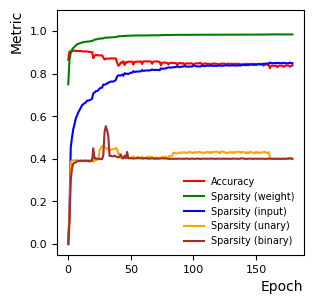

In [9]:
size_axis_title=10
size_axis_label=8
size_legend=7
plt.figure(figsize = (7,7))
axes = plt.subplot(2,2,1)
axes.set_ylim([-0.05,1.1])
plt.xticks(fontsize = size_axis_label) 
plt.yticks(fontsize = size_axis_label) 
axes.plot(history['accuracy'], label='Accuracy', linestyle='solid', c='r')
axes.plot(history['sparsity_model'], label='Sparsity (weight)', linestyle='solid', c='g')
axes.plot(history['sparsity_input'], label='Sparsity (input)', linestyle='solid', c='b')
axes.plot(history['sparsity_unary'], label='Sparsity (unary)', linestyle='solid', c='orange')
axes.plot(history['sparsity_binary'], label='Sparsity (binary)', linestyle='solid', c='brown')
axes.set_xlabel('Epoch', size=size_axis_title, loc='right')
axes.set_ylabel('Metric', size=size_axis_title, loc='top')
axes.legend(loc = 'best', frameon = False, fontsize = size_legend)
plt.show()

#### Evaluate on test sets

In [10]:
Y_pred = nsr.model.predict(X_test)
print("Accuracy = {}".format(accuracy_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))))

313/313 [==============================] - 1s 671us/step
Accuracy = 0.8483


# ROC

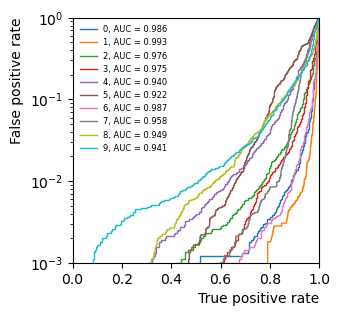

In [11]:
def plot_roc(y_test, y_pred, labels):
    for x, label in enumerate(labels):        
        fpr, tpr, _ = roc_curve(y_test[:, x], y_pred[:, x])
        plt.plot(tpr, fpr, label='{0}, AUC = {1:.3f}'.format(label, auc(fpr, tpr)), linestyle='-', lw=1.)
    plt.semilogy()
    plt.xlabel("True positive rate", size=10, loc='right')
    plt.ylabel("False positive rate", size=10, loc='top')
    plt.xlim(0, 1)
    plt.ylim(0.001, 1)
    plt.legend(loc='best', framealpha=0., prop={'size': 6})
    
plt.figure(figsize=(7, 7))
axes = plt.subplot(2,2,1)
plot_roc(Y_test, Y_pred, LE.classes_)

# Unroll network to get final expressions

In [12]:
# set significant digits for expression display
significant_digits = 2

# use sympy to expand the trained model
def get_expressions(neuralSR):
    model_dim, operators, num_operators = neuralSR.get_hyperparameters()
    input_dim, num_hidden_layers, output_dim = model_dim
    
    x=[]
    for i in range(input_dim):
        x.append(sympy.Symbol('x{}'.format(i)))
    x_masked = sympy.Matrix([x])
    
    w_input = neuralSR.model.layers[1].get_weights()[1]
    t_input = neuralSR.model.layers[1].get_weights()[0]
    num_input_masks = tf.reduce_sum(tf.cast(tf.where(w_input-t_input>0., 0., 1.),dtype=tf.float64))
    num_input_weights = tf.size(w_input, out_type=tf.float64)
    
    sparsity_input = num_input_masks/num_input_weights
    
    w_input_masked = sympy.Matrix(tf.where(w_input-t_input>0., w_input, 0.))
    x_print = np.multiply(sympy.Transpose(w_input_masked), x_masked)
    x_masked = np.multiply(sympy.Transpose(w_input_masked), x_masked)

    print('Remaining Inputs after pruning: {}\n'.format(str(x_masked).replace('1.0*','')))
    
    num_masks = 0.
    num_weights = 0.
    
    num_unary_masks = 0.
    num_binary_masks = 0.
    num_unary = 0.
    num_binary = 0.
    
    for i in range(num_hidden_layers+1):
        w = neuralSR.model.layers[i+2].get_weights()[0]
        b = neuralSR.model.layers[i+2].get_weights()[1]
        w_t = neuralSR.model.layers[i+2].get_weights()[2]
        b_t = neuralSR.model.layers[i+2].get_weights()[3]
        
        num_masks += tf.reduce_sum(tf.cast(tf.where(tf.abs(w) - w_t > 0., 0., 1.),dtype=tf.float64))
        num_masks += tf.reduce_sum(tf.cast(tf.where(tf.abs(b) - b_t > 0., 0., 1.),dtype=tf.float64))
        num_weights += tf.size(w, out_type=tf.float64)
        num_weights += tf.size(b, out_type=tf.float64)
        
        w_masked = sympy.Matrix(tf.where(tf.abs(w) - w_t > 0., w, 0.))
        b_masked = sympy.Transpose(sympy.Matrix(tf.where(tf.abs(b) - b_t > 0., b, 0.)))
        
        x_masked = (x_masked * w_masked + b_masked).evalf(significant_digits)
        if i < num_hidden_layers:
            unary = neuralSR.model.layers[i+2].get_weights()[6]
            unary_t = neuralSR.model.layers[i+2].get_weights()[4]
            binary = neuralSR.model.layers[i+2].get_weights()[7]
            binary_t = neuralSR.model.layers[i+2].get_weights()[5]
            num_unary_masks += tf.reduce_sum(tf.cast(tf.where(unary - unary_t > 0., 0., 1.),dtype=tf.float64))
            num_binary_masks += tf.reduce_sum(tf.cast(tf.where(binary - binary_t > 0., 0., 1.),dtype=tf.float64))
            num_unary += tf.size(unary, out_type=tf.float64)
            num_binary += tf.size(binary, out_type=tf.float64)
        elif i == num_hidden_layers:
            num_operators.append([output_dim, 0])
            operators.append([['identity'], [None]])
            
        y_masked = sympy.zeros(1, num_operators[i][0] + num_operators[i][1])
        
        unary_mask = sympy.Matrix(tf.where(unary - unary_t > 0., 1., 0.))
        binary_mask = sympy.Matrix(tf.where(binary - binary_t > 0., 1., 0.))
        for j in range(num_operators[i][0]):
            idx = np.mod(j, len(operators[i][0]))
            if i < num_hidden_layers:
                y_masked[0,j] = (unary_mask[j] * math_operation('sympy',operators[i][0][idx],x_masked[0,j]) +
                             (1.0 - unary_mask[j]) * math_operation('sympy','identity',x_masked[0,j]))
            elif i == num_hidden_layers:
                y_masked[0,j] = x_masked[0,j]
        for j in range(num_operators[i][1]):
            idx = np.mod(j, len(operators[i][1]))
            y_masked[0,num_operators[i][0]+j] = (binary_mask[j] * math_operation('sympy',operators[i][1][idx],x_masked[0,num_operators[i][0]+2*j],x_masked[0,num_operators[i][0]+2*j+1]) +
                                              (1.0 - binary_mask[j]) * math_operation('sympy','+',x_masked[0,num_operators[i][0]+2*j],x_masked[0,num_operators[i][0]+2*j+1]))
        x_masked = y_masked.evalf(significant_digits)
    
    sparsity_model = num_masks/num_weights
    sparsity_unary = num_unary_masks/num_unary
    sparsity_binary = num_binary_masks/num_binary
    
    complexity = []
    for j in range(len(x_masked)):
        c = 0
        for tree_node in sympy.preorder_traversal(x_masked[j]):
            c += 1
        complexity.append(c)
    
    return x_masked, complexity, sparsity_input, sparsity_model, sparsity_unary, sparsity_binary
  
expressions_masked, complexity, sparsity_input, sparsity_model, sparsity_unary, sparsity_binary = get_expressions(nsr)
print('Unroll network into symbolic expressions (input sparsity = {0:.3f}; model sparsity = {1:.3f}; unary sparsity = {2:.3f}; binary sparsity = {2:.3f})\n--------------'.format(sparsity_input, sparsity_model, sparsity_unary, sparsity_binary))
print('Mean complexity = {0:.1f}\n--------------'.format(np.mean(complexity)))
for i in range(expressions_masked.shape[1]):
    print('expr_{0} (complexity = {1}):\n\n{2}\n-------------------------------------'.format(i,complexity[i],expressions_masked[i]))

Remaining Inputs after pruning: [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 x64 0
  x66 0 x68 0 x70 x71 0 x73 0 x75 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 x94 0 0 x97 0 x99 0 x101 0 x103
  0 0 x106 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 x125 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 x145 0 0 0 0 0 x151 0 x153 0 0 0 0
  0 0 0 0 x162 0 0 x165 0 0 0 0 0 0 0 0 x174 0 0 x177 0 0
  0 x181 0 x183 0 0 0 0 0 x189 0 0 x192 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 x219 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  x234 0 0 0 0 x239 0 0 0 x243 0 0 0 x247 0 x249 0 0
  0 0 0 x255 0 0 0 0 0 0 0 0 x264 0 0 0 0 x269 0 0 x272 0
  0 0 x276 0 0 0 0 0 0 x283 0 0 0 0 0 x289 x290 x291
  0 0 0 0 0 0 0 0 x300 0 x302 0 0 x305 0 0 0 0 0 0 0 0 0
  x315 0 0 0 0 0 0 0 0 x324 0 x326 0 0 0 0 0 0 0 0 0 0 0 0
  x339 0 0 0 0 x344 0 x346 0 x348 0 x350 x351 0 0
  0 0 x356 0 0 x359 0 0 0 0 0 0 0 0 0 0 0 x371 0 0 x374
  x375 x376 x377 0 0 0 0 0 0

# Check output consistency before and after network unrolling (LHC jet tagging)

#### Feed one example and get model output from tf model

In [ ]:
n=123
nsr.model.predict(X_test[n].reshape(1,-1))

#### Get all inputs from this example as x_i

In [ ]:
# 16 inputs in LHC jet tagging dataset
x0=X_test[n,0]
x1=X_test[n,1]
x2=X_test[n,2]
x3=X_test[n,3]
x4=X_test[n,4]
x5=X_test[n,5]
x6=X_test[n,6]
x7=X_test[n,7]
x8=X_test[n,8]
x9=X_test[n,9]
x10=X_test[n,10]
x11=X_test[n,11]
x12=X_test[n,12]
x13=X_test[n,13]
x14=X_test[n,14]
x15=X_test[n,15]

#### Copy the expression from the output of get_expressions then evaluate to see if it matches with the tf model output

In [ ]:
from numpy import sin, cos, sinh, cosh, tanh, log, exp
from numpy import abs as Abs

In [ ]:
-0.08228*(-0.004546*x12 + 0.0549*x14 - 0.8765*sin(0.4284*x12 - 1.296*x14))*(-0.1472*x3*(0.6581*x14 - 0.3985*x15) + 0.579*sin(1.746*x14 - 1.63*x3) - 0.6472) + 0.3013*(0.03965*x15*(0.5406*x15 - 0.2531*x3) + 0.2365*tanh(0.7771*x15 - 0.6186*x3) - 1.315*tanh(4.758*x14 + 0.3745*x15 + 1.507*x3 - 0.9826) - 0.1219)*(0.2884*(0.2513*x12 + 0.38*x14)*(0.382*x12 - 0.4181*x15) + 0.2111*tanh(0.7771*x15 - 0.6186*x3) + 1.609*tanh(4.758*x14 + 0.3745*x15 + 1.507*x3 - 0.9826) - 0.6536*exp(-90.08*(-0.1198*x14 - 0.007836*x15 - x3 - 0.01278)**2) + 1.067*exp(-48.39*(x14 + 0.06604*x3 - 0.07651)**2)) - 0.4192*tanh(0.1233*x15*(0.5406*x15 - 0.2531*x3) + 0.2512*tanh(0.6489*x15) - 0.7522*exp(-90.08*(-0.1198*x14 - 0.007836*x15 - x3 - 0.01278)**2)) + 0.709*exp(-3.114*(-0.1731*sin(1.746*x14 - 1.63*x3) + exp(-48.39*(x14 + 0.06604*x3 - 0.07651)**2))**2)